# Project: Classification - Loan Eligibility Prediction

## Marks: 30

Welcome to the project on classification. We will use the credit risk dataset for this problem.

----------------
## Context: 
----------------

Credit risk is the risk of loss resulting from the failure by a borrower to repay the principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## Objective:
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, the customer first applies for a home loan post which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate the loan eligibility process. They want to harness their past customers' data to build a model to predict whether the loan should be approved or not. This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [2]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [4]:
data.Loan_ID.nunique()

614

- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [5]:
data.drop(columns=['Loan_ID'], inplace=True)

#### Summary Statistics for numerical columns

#### Question 1: Write the observations from the below summary statistics (2 Marks) 

In [6]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


# print summary statistics 
num_cols_desc = data[num_cols].describe().T

# add helpful columns 
num_cols_desc['range'] = num_cols_desc['max'] - num_cols_desc['min']
num_cols_desc['std / mean'] = num_cols_desc['std'] / num_cols_desc['mean']

display(num_cols_desc)

,count,mean,std,min,25%,50%,75%,max,range,std / mean
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0,80850.0,1.130580
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0,41667.0,1.804938
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0,700.0,0.625792
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0,468.0,0.190411


**Observations:**
* All four variables have very different ranges (700 for `LoanAmount` v 81K for `ApplicantIncome` for example). It will be important to scale these data.
* `LoanAmount` minimum is 0. This is odd since nobody would apply for a loan of USD0! We need to inspect this, as it might be an error.
* We're missing `Loan_Amount_Term` for 14 records. Perhaps we can impute them, or perhaps it's related to having some `LoanAmount` of USD0
* There is a wide spread of data in the Income related variables, with the standard deviation higher than the mean. This suggests a skewed distribution when combined with noticing the median being lower than the mean. We'll see this in EDA if it's an issue.


#### Feature Engineering

In [7]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [8]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [9]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Check the distribution and outliers for each column in the data

LoanAmount
Skew : 2.36


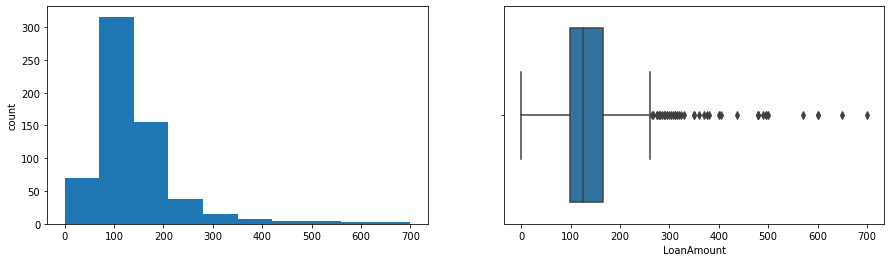

total_income
Skew : 5.63


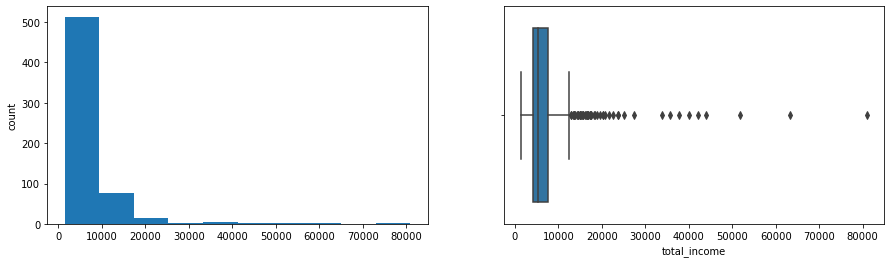

In [10]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10K.

Now, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

#### Question 2: 

- **Write the code to check the percentage of each category for categorical columns (cat_col) (2 Marks)**
- **Write your observations (2 Marks)**

In [11]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True)) #Write your code here
    print('*'*40)                                  #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**
* A lot of these categories are uneven. For example, the data is 81% male and 19% female, 78% of customers have a Graduate education, 84% have sufficient Credit History, and 86% aren't self-employed. We'll have to make sure that the train test split reflects similar representation.
* Property Area seems roughly evenly distributed
* Our dependent variable `Loan_Status` is not evenly balanced (69% approved, 31% not approved) so this might pose some issues. We'll be able to play around with weights if needed. 

#### Imputing missing values

In [12]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [13]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**Now that we are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

Let's check the relationship of loan amount with the total income.

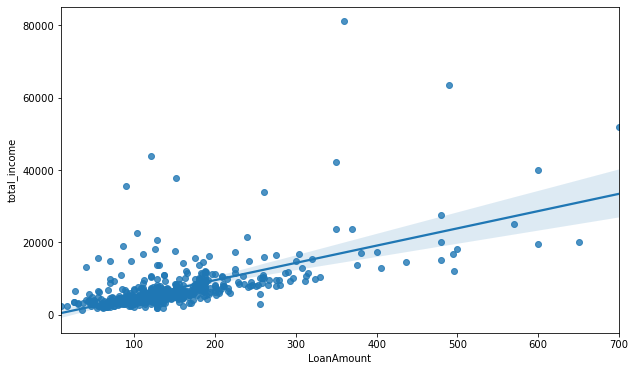

In [14]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relationship of total income with loan status

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

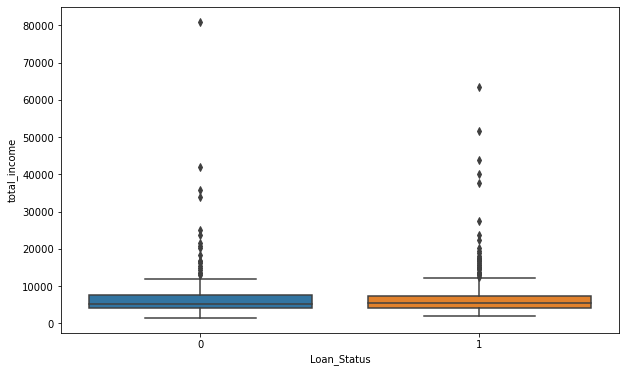

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data.Loan_Status, y=data.total_income)

- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

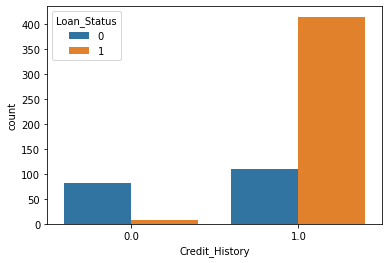

In [16]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

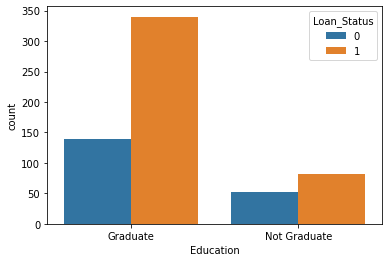

In [17]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

<AxesSubplot:xlabel='Education', ylabel='total_income'>

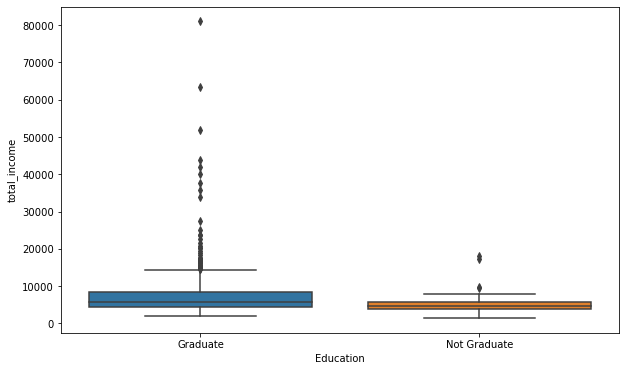

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data.Education, y=data.total_income)

- We can see that this does appear to be true; graduate customers seem to earn more on average.

Let's check how property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

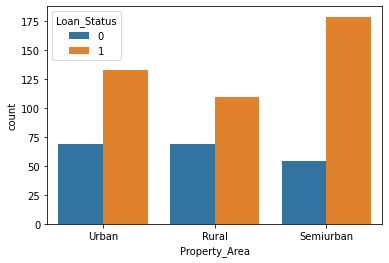

In [19]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

#### Question 3: 

- **Drop the target variable from the original data and store it in a separate dataframe `X` (1 Mark)**
- **Store the target variable in a separate series `Y` (1 Mark)**

In [20]:
#Separating target variable and other variables

X = data.drop(columns='Loan_Status')
Y = data['Loan_Status'] 

In [21]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [22]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [23]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

#### Question 4: Fit the logistic regression model on the train dataset using random_state=1 (2 Marks)

In [24]:
#define logistic regression model the model
log_reg = LogisticRegression(random_state=1)

#fit the model
log_reg.fit(X_train, y_train)


LogisticRegression(random_state=1)

**Let's check the coefficient of each dependent variable in the data**

#### Question 5: Write your observations on the below coefficients obtained from the logistic regression model (3 Marks)

In [25]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.293414
Property_Area_Semiurban    0.770518
Dependents_3+              0.312889
Married_Yes                0.292060
Dependents_2               0.153514
Property_Area_Urban        0.000783
total_income              -0.000011
LoanAmount                -0.000821
Loan_Amount_Term          -0.066287
Self_Employed_Yes         -0.115254
Gender_Male               -0.182863
Dependents_1              -0.223181
Education_Not Graduate    -0.442318
dtype: float64

**Observations:**

**Features which positively affect Loan Approval are:**
* Credit History: It has the biggest impact
* Living in Semi-Urban Area
* Being married
* Having 2 or 3+ dependents (which is probably heavily correlated with being single / married)

**Features which negatively affect loan approval are:**
* Not graduating school (strongest negative effect)
* Having just 1 dependent
* Being male
* Being self employed (which suggests possible instability of income)
* Loan Amount terms

**A few features have barely any impact:**
* Income 
* Loan Amount
* Property Area Irban

#### Question 6: Write your interpretations of the odds calculated from the logistic regression model coefficients (3 Marks)

In [26]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

# adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,26.934651
Property_Area_Semiurban,2.160886
Dependents_3+,1.367370
Married_Yes,1.339184
Dependents_2,1.165924
Property_Area_Urban,1.000783
total_income,0.999989
LoanAmount,0.999179
Loan_Amount_Term,0.935862
Self_Employed_Yes,0.891139


**Observations:**
* A customer with good credit history is almost 21X more likely to see their loan approved. It is the single biggest determinant.
* Living in Semi Urban area increases one's odds of getting approved by 2.3X (130%)
* Being Married, having 2 or 3+ dependents, all increase odds a bit (between +12% and +21%), compared to their reference (respectively "Not being married" and "Having 0 dependents")
* Conversely, not graduating school decreases one's odds of getting approved by almost 40%, while all others features affect negatively between -14% and -7%, i.e. moderate effect.

Income and loan amount have virtually no effect (same with Property Area Urban) so we might be able to drop these.

**Now, let's check the performance of the model on the training set**

#### Question 7: Check the performance on the training data and write your observations from the below classification report and confusion matrix for the training set (3 Marks)

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



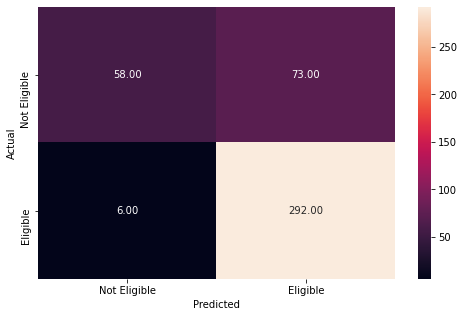

In [27]:
#predict on the training data 
y_pred_train = log_reg.predict(X_train)


# Checking performance on the training data
metrics_score(y_train, y_pred_train)

**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is not eligible and the customer is actually not eligible
- **False Negative**: Predicting the customer is eligible but the customer is actually not eligible
- **True Negative**: Predicting the customer is eligible and the customer is actually eligible
- **False Positive**: Predicting the customer is not eligible but the customer is actually eligible

**Observations:**

The class we care about is 0 (Not Eligible) and the metric we care about is Recall (predicting someone is eligible when in fact they're not). In other words, we **do not want to say someone is eligible when they won't be, as it can cost a lot of money with risks of default**.

With this model, we have a very low recall (0.44), meaning that for 44% **actually ineligible** users we predicted they'd be eligible. We were **wrong** more often than we were right.

The model's **accuracy** is high at 82%, but not that far from what we'd have predicted if we had said "Everyone is eligible" (only 31% are eligible, so our accuracy would have been 69%).

We have high **Precision** (0.91), meaning that of those we predicted to not be eligible, we were right 91% of the time. This is however not the metric we care about for this model, but still something to keep an eye on. 

Overall, this model is not very good, so we need to tune its parameters.

**Precision-Recall Curve for Logistic Regression**

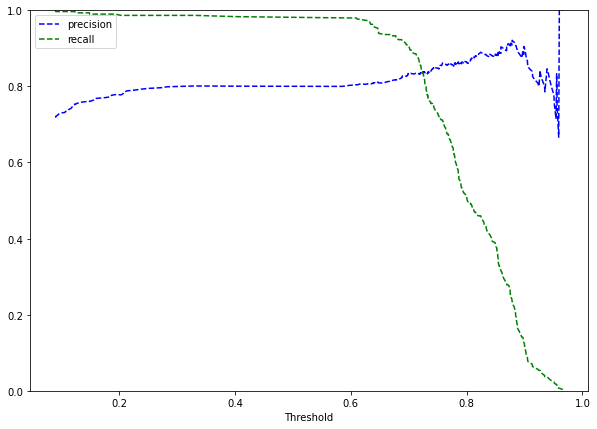

In [28]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [29]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7234637570322128


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

#### Question 8: Compare the performance of the model on training and testing sets after changing the threshold (2 Marks)

              precision    recall  f1-score   support

           0       0.53      0.70      0.61       131
           1       0.85      0.73      0.78       298

    accuracy                           0.72       429
   macro avg       0.69      0.72      0.69       429
weighted avg       0.75      0.72      0.73       429



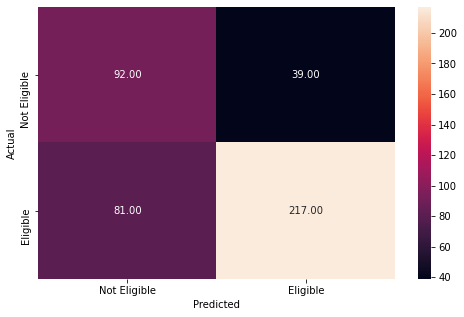

In [30]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60        61
           1       0.81      0.77      0.79       124

    accuracy                           0.72       185
   macro avg       0.69      0.70      0.70       185
weighted avg       0.73      0.72      0.73       185



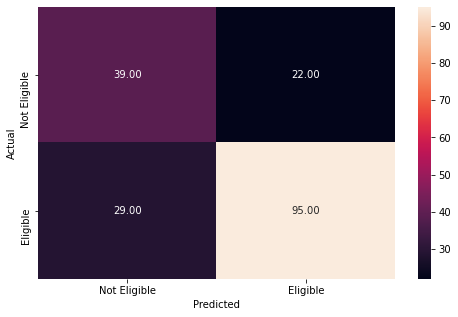

In [31]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

**Observations:**

**Recall** has improved after choosing a threshold of 0.75 (73% recall), but **Precision** dropped a lot (51%). While the company wants to optimize for Recall, we might need to make sure that the the money it saves from approving fewer "bad" customers is not inferior to the money it loses by rejecting more "good" customers.

In addition, **Recall** dropped to 66% in the test set, and precision didn't improve a lot, so the model didn't **generalise** well to the test data.

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set (30 times)
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [32]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.2662790697674418],
 2: [0.11243926141885321, 0.331782945736434],
 3: [0.1550048590864917, 0.24844961240310076],
 4: [0.16141885325558797, 0.27558139534883713],
 5: [0.1850340136054422, 0.2217054263565892],
 6: [0.18503401360544214, 0.2333333333333334],
 7: [0.1926141885325559, 0.22054263565891472],
 8: [0.19718172983479104, 0.20658914728682168],
 9: [0.19805636540330424, 0.21472868217054272],
 10: [0.19786200194363465, 0.21434108527131782],
 11: [0.19941690962099123, 0.21860465116279074],
 12: [0.19805636540330418, 0.21201550387596904],
 13: [0.20612244897959187, 0.19341085271317837],
 14: [0.19844509232264335, 0.19806201550387606],
 15: [0.20077745383867834, 0.21201550387596899],
 16: [0.19455782312925177, 0.20813953488372092],
 17: [0.2014577259475219, 0.20968992248062016],
 18: [0.20058309037900876, 0.19728682170542639],
 19: [0.2050534499514092, 0.2042635658914729],
 20: [0.19659863945578232, 0.2104651162790698]}

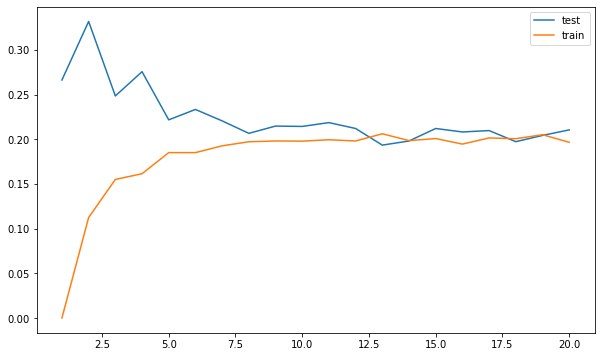

In [33]:
# Extracting k and the test error in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error error
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

- 

- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [34]:
# scaling the data
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [35]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

#### Question 9: 

- **Check the performance of the model on the training and testing data (2 Marks)**
- **Compare the performance and write your observations (2 Marks)**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



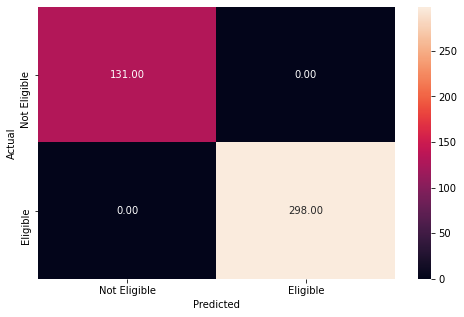

In [36]:
#predict on train data
y_pred_train_knn = knn.predict(X_train_scaled)# write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:**

The recall is 100%. In fact, all metrics are 100%.
This strongly suggests the model is overfitted and will not generalise well -- particularly since we saw above the average score with 7 neighbors was 0.8.

Let's still check on the test data.

              precision    recall  f1-score   support

           0       0.61      0.31      0.41        61
           1       0.73      0.90      0.81       124

    accuracy                           0.71       185
   macro avg       0.67      0.61      0.61       185
weighted avg       0.69      0.71      0.68       185



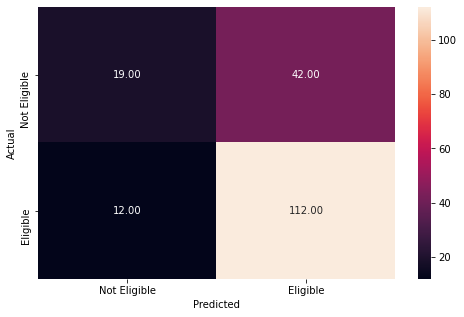

In [37]:
#predict on test data
y_pred_test_knn = knn.predict(X_test_scaled)# Write your code here

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:**
* As expected, the results in the training set were a fluke, as we now have a recall of 31%, which is much worse than with Logistic Regression.
* This is a case where we had overfitted the model, so we'd proceed with hyper-parameters tuning, perhaps playing around with the distance measure, or also consider dropping features.

#### Question 10: Write the conclusion on the key factors that are driving the approval of loan and write your recommendations to the business on how can they minimize the credit risk. (5 Marks)

## Conclusion:

* We analysed the relationship between variables and proceeded to EDA.
* We learned that Income didn't have a strong relationship with Loan Approval, and neither did Loan Amount
* We also learned that Credit History had a huge impact on Loan Approval.
* We decided to prioritise Recall as a performance metric, due to the risk associated with false positives: If we approve someone we shouldn't, it caries financial risks such as loan default that *might* outweigh loss of revenue from approving loans to good customers.
* We tested two algorithms: Logistic Regression, and K-Nearest Neighbors with a weight on distance. 
* We proceeded to validation on the test sets for both of these algorithms.
* K-Neared Neighbors did NOT generalise well and was overfitted in training.
* Logistic Regression gave us a Recall of 0.66 on the test set - which is not very good, so we'd likely proceed to cost estimates of that risk level with the company.

## Recommendations:

Based on the findings, we identified that Credit History, purchasing in semi-urban area, and being married traditionally were the three biggest contributors to loan Approval.

* If the Credit History was good, customers were 21X more likely to be approved.
* Buying in semi-urban areas and being married respectively increased the odds by 2.3X and 1.2X

Conversely, not graduating school, having 1 dependent, and being male all decreased odds.

If we wanted to automatise the Loan Approval process, we should focus on Credit History, and then, all else held equal, focus on the location of the property.

Income and LoanAmount typically did not have an impact - this might be a fluke, or it might be because Credit History is somewhat related to Income already.